# Workshop MLflow

__*Objectives*__

Use **ML Flow Tracking** to follow a model key metrics

__*Steps*__

1. Import Libs
2. Load cleaned data
    * Load CSV
    * Short Data description
3. Understand the data
    * Pandas Profiling
4. Machine Learning
    * Preprocess
    * Metrics
    * Models
    * Results
5. MLFlow
    

In [8]:
import pandas as pd
import numpy as np
import os
import pandas_profiling as pdp
import mlflow
import mlflow.sklearn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# Display all the columns of Pandas Dataframe
pd.options.display.max_columns = None

## Import data set

In [4]:
df_all = pd.read_csv('./data/energydata_complete.csv')

print('nb observations: {} - nb features: {}'.format(*df_all.shape))
df_all.head()

nb observations: 19735 - nb features: 29


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


## Information about the data set

Column Name  | Description | Unit
------------ | ----------- | -----------
date | year-month-day hour:minute:second | 
lights | energy use of light fixtures the house | Wh 
T1 | Temperature in kitchen area, | Celsius 
RH_1 | Humidity in kitchen area, | % 
T2 | Temperature in living room area, | Celsius 
RH_2 | Humidity in living room area, | % 
T3 | Temperature in laundry room area 
RH_3 | Humidity in laundry room area, | % 
T4 | Temperature in office room, | Celsius 
RH_4 | Humidity in office room, | % 
T5 | Temperature in bathroom, | Celsius 
RH_5 | Humidity in bathroom, | % 
T6 | Temperature outside the building (north side), | Celsius 
RH_6 | Humidity outside the building (north side), | % 
T7 | Temperature in ironing room , | Celsius 
RH_7 | Humidity in ironing room, | % 
T8 | Temperature in teenager room 2, | Celsius 
RH_8 | Humidity in teenager room 2, | % 
T9 | Temperature in parents room, | Celsius 
RH_9 | Humidity in parents room, | % 
To | Temperature outside (from Chievres weather station), | Celsius 
Pressure | (from Chievres weather station), | mm Hg 
RH_out | Humidity outside (from Chievres weather station), | % 
Wind speed | (from Chievres weather station), | m/s 
Visibility | (from Chievres weather station), | km 
Tdewpoint | (from Chievres weather station), Â°C 
rv1 | Random variable 1, nondimensional 
rv2 | Random variable 2, nondimensional 
------------ | ----------- | -----------
Appliances | energy use | Wh


We will create a report named `report-all-data.html` in the repo `./analysis`.
This report helps us to understand all distribution and correlation in the data set. You can go into that repo and open it in your browser

In [6]:
# Just Random variable for robustness
df_all.drop(columns=['date', 'rv1', 'rv2'], inplace=True)

## Get report analysis : [PandasProfiling](https://github.com/pandas-profiling/pandas-profiling)

In [9]:
if not os.path.exists("./analysis"):
    os.mkdir("./analysis") # Create repo because does not exist

In [10]:
profile = pdp.ProfileReport(df_all)
profile.to_file(outputfile="./analysis/report-all-data.html")

Let's have a look at the created [report](./analysis/report-all-data.html)

## Let's talk about Machine Learning

__*What is the objective of the model?*__

=> Predict the Quantity of Energy used

We will use a first ML model to see what kind of information we need to record to (for example) evaluate the capacity of the model, if we suffer from overfitting or underfitting etc. From that we will understand why `mlflow` is a great tool for tracking metrics and save artifacts.

If you looked at the report you've seen that we have some categorical features. We encode them first

## Preprocess

In [11]:
from sklearn.model_selection import train_test_split

target_column = "Appliances" # "y"

train, test = train_test_split(df_all) # default test size 1/4

train_x = train.drop([target_column], axis=1)
test_x = test.drop([target_column], axis=1)
train_y = train[target_column]
test_y = test[target_column]

## Metrics to evaluate the results

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


def scatter_plot_result(y_actual, y_pred, model_name):
    plt.scatter(y_actual, y_pred)
    plt.ylabel('Target predicted')
    plt.xlabel('True Target')
    plt.title(model_name)
    plt.text(500, 250, r'$RMSE=%.2f, R^2$=%.2f, MAE=%.2f' % (np.sqrt(mean_squared_error(y_actual, y_pred)), 
                                              r2_score(y_actual, y_pred), 
                                              mean_absolute_error(y_actual, y_pred)))
    plt.savefig('./scatter_results-{}.png'.format(model_name))
    plt

## Build our first model

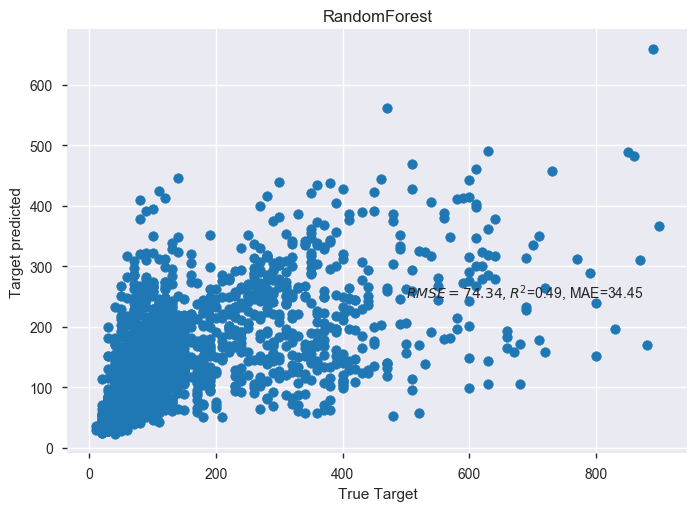

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Train model
rfp = RandomForestRegressor(random_state=0, n_estimators=100)
model = rfp.fit(train_x, train_y)


pred_test = model.predict(test_x)
# print('rmse: {} - mae: {} - r2: {}'.format(*eval_metrics(test_y, pred_test)))
scatter_plot_result(test_y, pred_test, 'RandomForest')

-> `Retrain your model with another set of parameters and compare results`

## Build a second model

Often, we use a second model in order to challenge the first one...

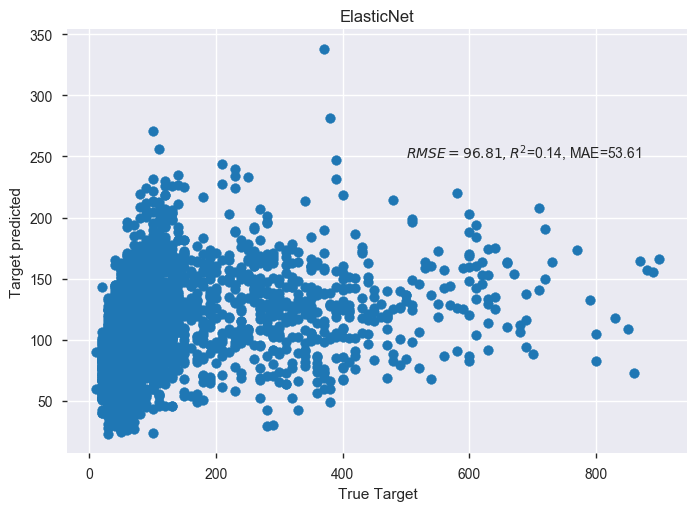

In [17]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import QuantileTransformer, quantile_transform


# Train model
lr = ElasticNet(random_state=0, alpha=0.5, l1_ratio=0.2)
model = lr.fit(train_x, train_y)


pred_test = model.predict(test_x)
# print('rmse: {} - mae: {} - r2: {}'.format(*eval_metrics(test_y, pred_test)))
scatter_plot_result(test_y, pred_test, 'ElasticNet')

-> `Retrain your model with another set of parameters and compare results`

# Utility of ML Flow

At this point you may want to draw more visualizations to compare your models :
    * performance, 
    * feature importance
    * other metrics

You understand that we will have do this process **EVERY TIME**, to compare or analyse any model or ML code. 

Also, **if your data change**, your metrics can change. It would be great to have the history of the data ATTACHED to the code's history

__*This is where Tracking with MLflow is useful*__

Same exercise in `train.py`. 

In [60]:
from sklearn.compose import TransformedTargetRegressor

# If you wish to try on classification problem
def log_metrics_classification(y_true, y_prediction):
    report = classification_report(y_true, y_prediction, output_dict=True)
    for class_ in ['0', '1']:
        for metric in report[class_]:
            log_name = class_ + '_' + metric
            # insert your code here ~ 1 line
         
        
def log_metrics_regression(y_true, y_prediction):
    rmse, mae, r2 = eval_metrics(y_true, y_prediction)
    # log metrics here ~ 3 lines


def run_experiment(df, alpha, l1_ratio):    
    # Split data
    train, test = train_test_split(df)
    
    train_x = train.drop([target_column], axis=1)
    test_x = test.drop([target_column], axis=1)
    train_y = train[target_column]
    test_y = test[target_column]

    with mlflow.start_run():
        print("Running with alpha: {} - l1_ratio: {}".format(alpha, l1_ratio))

        # fit models
        lr = ElasticNet(random_state=0, alpha=alpha, l1_ratio=l1_ratio)
        lr.fit(train_x, train_y)

        prediction_test = lr.predict(test_x)

        # log parameters
        # Your code here ~ 2 lines

        # log artifact
        scatter_name = './scatter_results-ElasticNet.png'
        # save scatter plot as artifact here ~ 2 lines

        # log metrics
        log_metrics_regression(test_y, prediction_test)

        # log sklearn model
        # log the sklearn model here  ~ 1 line
        

In [68]:
# play yourself with parameters
# ! both parameters have min 0 and max 1 ! 


# Remove break to see all runs
for alpha in np.arange(0.1, 1, 0.2):
    for l1_ratio in np.arange(0.1, 1, 0.2):
        run_experiment(df_all, alpha, l1_ratio)
        break
    break

Running with alpha: 0.1 - l1_ratio: 0.1
